# Data Collecting

In [164]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score

In [144]:
df = pd.read_csv('../data/stroke.csv')

In [ ]:
df.shape

In [67]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [ ]:
df.head()

In [ ]:
df.dtypes

In [ ]:
df.describe()

In [4]:
label = 'stroke'
df[label].value_counts()/df.shape[0]

0    0.981959
1    0.018041
Name: stroke, dtype: float64

The balance of data is low.

# Data Preprocessing

'id' identifies unique individual. It is not a contributing factor to stroke. So I will drop the 'id' column.

In [145]:
df.drop(columns=['id'], inplace=True)

In [ ]:
df.isnull().sum(axis=0)

In [ ]:
df.isnull().sum(axis=0)/df.shape[0]*100

The dataset contains missing values in 'bmi' and 'smoking_status'.

People who do not fill in 'smoking_status' information may have similar reasons why they don't. So I will replace the missing values in 'smoking_status' with 'missing' as a separate category.

In [177]:
label = 'stroke'
bin_ftrs = ['hypertension', 'heart_disease']
onehot_ftrs = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_ftrs = ['age', 'avg_glucose_level', 'bmi']

In [189]:
def preprocess(X_train, X_CV, X_test, random_state, linear=False):
    onehot_enc = OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore')
    cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
    onehot_encoded = onehot_enc.fit_transform(cat_imputer.fit_transform(X_train[onehot_ftrs]))
    X_train_oh = pd.DataFrame(onehot_encoded, columns=onehot_enc.get_feature_names())
    X_CV_oh = onehot_enc.transform(cat_imputer.transform(X_CV[onehot_ftrs]))
    X_CV_oh = pd.DataFrame(X_CV_oh, columns=onehot_enc.get_feature_names())
    X_test_oh = onehot_enc.transform(cat_imputer.transform(X_test[onehot_ftrs]))
    X_test_oh = pd.DataFrame(X_test_oh, columns=onehot_enc.get_feature_names())
                
    scaler = MinMaxScaler()
    iter_imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators=100), 
                                    random_state = random_state)
    mm_scaled = scaler.fit_transform(iter_imputer.fit_transform(X_train[num_ftrs]))
    X_train_num = pd.DataFrame(mm_scaled, columns=num_ftrs)
    X_CV_num = scaler.transform(iter_imputer.transform(X_CV[num_ftrs]))
    X_CV_num = pd.DataFrame(X_CV_num, columns=num_ftrs)
    X_test_num = scaler.transform(iter_imputer.transform(X_test[num_ftrs]))
    X_test_num = pd.DataFrame(X_test_num, columns=num_ftrs)
        
    X_train_bin = X_train[bin_ftrs]
    X_CV_bin = X_CV[bin_ftrs]
    X_test_bin = X_test[bin_ftrs]
    X_train_bin.reset_index(drop=True, inplace=True)
    X_CV_bin.reset_index(drop=True, inplace=True)
    X_test_bin.reset_index(drop=True, inplace=True)
        
    X_train_ = pd.concat([X_train_bin, X_train_oh, X_train_num], axis=1)
    X_CV_ = pd.concat([X_CV_bin, X_CV_oh, X_CV_num], axis=1)
    X_test_ = pd.concat([X_test_bin, X_test_oh, X_test_num], axis=1) 
    
    if linear:
        std_scaler = StandardScaler()
        std_scaled = std_scaler.fit_transform(X_train_)
        X_train_linear = pd.DataFrame(std_scaled, columns=X_train_.columns)
        X_CV_linear = pd.DataFrame(std_scaler.transform(X_CV_), columns=X_train_.columns)
        X_test_linear = pd.DataFrame(std_scaler.transform(X_test_), columns=X_train_.columns)
        return X_train_linear, X_CV_linear, X_test_linear
    
    return X_train_, X_CV_, X_test_

In [190]:
proc_ftrs = ['hypertension', 'heart_disease', 'gender_Female', 'gender_Male', 'gender_Other',
             'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked', 
             'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural',
             'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_missing', 
             'smoking_status_never smoked', 'smoking_status_smokes', 'age', 'avg_glucose_level', 'bmi']

# Models

### metric baselines

In [149]:
# precision
r = len(df[df[label]==1])/df.shape[0]
base_f1 = 2*r/(r+1)
print('f1 score base line is {}.'.format(base_f1))

f1 score base line is 0.03544349636738112.


In [150]:
y = df[label]
X = df.drop(columns=[label])

#### Logistic regression

In [ ]:
def ML_pipeline_kfold_logistic(X, y, random_state, n_folds):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                        random_state=random_state)
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    f1_scores = []
    best_alphas_f1 = []

    for train_index, CV_index in kf.split(X_other, y_other):
        X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
        y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]

        X_train_, X_CV_, X_test_ = preprocess(X_train, X_CV, X_test, random_state)
        
        alpha = np.logspace(-5, 2, num=20)
        clfs = []
        thresholds = []
        CV_score_f1 = []
        
        for a in alpha:
            clf = LogisticRegression(penalty='l1', C=1/a, max_iter=10000, solver='saga',
                                    multi_class='auto')
            clf.fit(X_train_, y_train)
            
            y_train_prob = clf.predict_proba(X_train_)
            thres = min([prob2 for [prob1, prob2] in y_train_prob])
            y_CV_prob = clf.predict_proba(X_CV_)
            y_CV_prob = [prob2 for [prob1, prob2] in y_CV_prob]
            y_CV_pred = [1 if prob>thres else 0 for prob in y_CV_prob]
            
            CV_score_f1.append(f1_score(y_CV, y_CV_pred))
            thresholds.append(thres)
            clfs.append(clf)
        
        best_alpha_f1 = alpha[np.argmax(CV_score_f1)]
        best_alphas_f1.append(best_alpha_f1)
        clf = clfs[np.argmax(CV_score_f1)]
        thres = thresholds[np.argmax(CV_score_f1)]
        y_test_prob = clf.predict_proba(X_test_)
        y_test_prob = [prob2 for [prob1, prob2] in y_test_prob]
        y_test_pred = [1 if prob>thres else 0 for prob in y_test_prob]
        f1_scores.append(f1_score(y_test,y_test_pred))

    best_a_f1 = best_alphas_f1[np.argmax(f1_scores)]
    return best_a_f1, f1_scores, clf

f1_scores_l = []

for i in range(10):
    random_state = 42*i
    best_a_f1, f1_scores, clf_l = ML_pipeline_kfold_logistic(X, y, random_state, 5)

    f1_scores_l.append(f1_scores)
    print('random state = {}:'.format(random_state))
    print('Best alpha for f1 score is {}'.format(best_a_f1))

mean_f1_l = np.mean(f1_scores_l)
std_f1_l = np.std(f1_scores_l)
print('test recall score:', np.around(mean_f1_l,3), '+/-', np.around(std_f1_l,3))

#### Logistic Regression -- global feature importance

[ 0.0068517  -0.0068517   0.00983729  0.0121312  -0.01271691  0.01271691
 -0.02895882 -0.03288331 -0.038104   -0.03877539 -0.04000032  0.04134401
  0.06119675 -0.07926998  0.0889143   0.11359191  0.12015623  0.13392119
  0.16117896 -0.27856895  1.46956451]


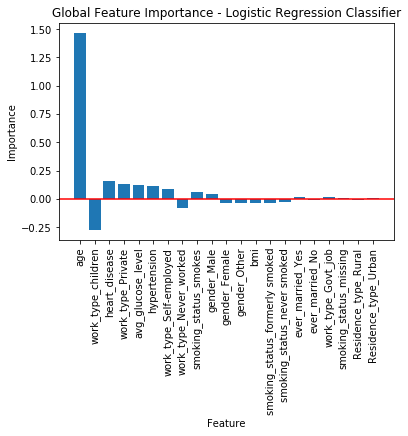

[ 0.00524609  0.01505457 -0.01532182  0.01532182 -0.02436514 -0.02901526
 -0.02978016  0.03054888  0.03108099 -0.03152958  0.03369966 -0.03369966
 -0.03762561  0.05372701 -0.072797    0.07535397 -0.10229754  0.10659917
  0.13780462  0.13918309  1.58354219]


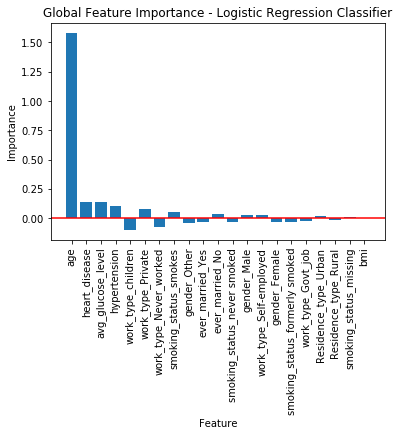

[-6.93721860e-04  6.93721860e-04 -6.42000682e-03  8.87154125e-03
  1.20242609e-02  1.42451700e-02 -2.18684658e-02 -2.60631107e-02
  2.64910029e-02 -2.64910029e-02 -2.96632825e-02 -3.20359544e-02
  3.25714452e-02  3.55155814e-02  6.57089911e-02 -7.34295924e-02
  8.21075356e-02 -1.06452235e-01  1.38410917e-01  1.39206605e-01
  1.55449181e+00]


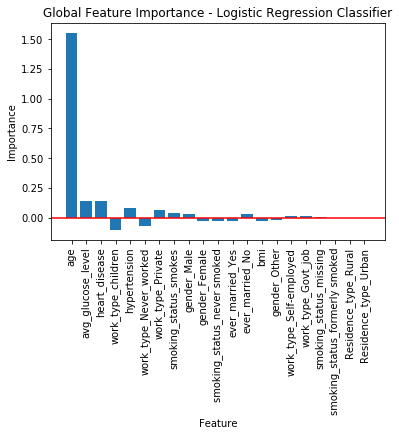

[-0.00357102  0.00357102 -0.01028274  0.01057633 -0.01057633 -0.01555904
  0.02281712  0.02460403 -0.0398916   0.04213678 -0.04640504 -0.05387478
  0.05534155 -0.06830553 -0.06963691  0.0856737  -0.11814241  0.11865762
  0.14047865  0.14398802  1.55601301]


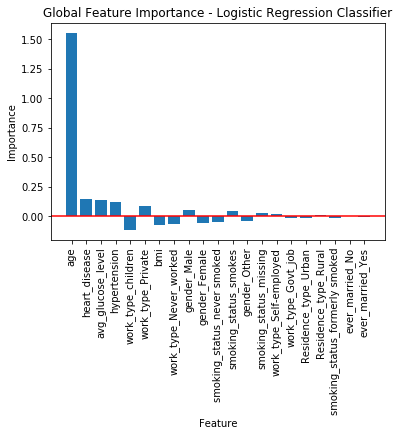

[ 0.00493251  0.00701553 -0.00701553 -0.00734181 -0.0117637  -0.012517
  0.01363806  0.018339   -0.03465828 -0.04137331 -0.04537465  0.05207312
 -0.05588376  0.05588376  0.0754559  -0.07905547  0.10047431 -0.10382341
  0.1419156   0.15730932  1.61434553]


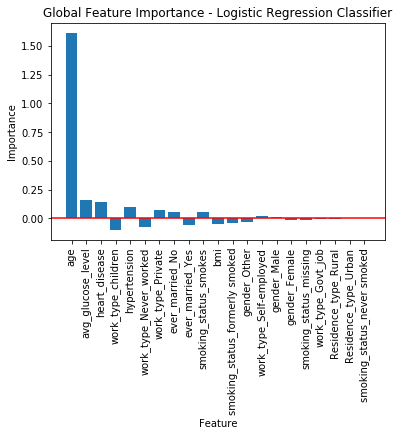

In [232]:
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=294)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=294)
a = 7.84759970e+00
ind = 0
for train_index, CV_index in kf.split(X_other, y_other):
    X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
    y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]

    X_train_, X_CV_, X_test_ = preprocess(X_train, X_CV, X_test, random_state=294, linear=True)
        
    clf_l = LogisticRegression(penalty='l2', C=1/a, max_iter=10000, solver='saga',
                             multi_class='auto')
    clf_l.fit(X_train_, y_train)
    coefs = clf_l.coef_[0]
    sorted_indcs = np.argsort(np.abs(coefs))
    proc_coef_ftrs = [proc_ftrs[i] for i in sorted_indcs][::-1]

    print(coefs[sorted_indcs[:]])
    plt.bar(range(len(coefs)), coefs[sorted_indcs[::-1]])
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title("Global Feature Importance - Logistic Regression Classifier")
    plt.xticks(range(len(coefs)), proc_coef_ftrs, rotation='vertical')
    plt.axhline(y=0, color='r')
    plt.savefig('../figures/logistic_regression_global_ftr_importance{}'.format(ind),
                dpi=300, bbox_inches = "tight")
    plt.show()
    ind += 1
         

#### Random Forest

In [ ]:
def ML_pipeline_kfold_random_forest(X, y, random_state, n_folds):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                        random_state = random_state)
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    f1_scores = []
    best_paras_f1 = []

    for train_index, CV_index in kf.split(X_other, y_other):
        X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
        y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]
        
        X_train_, X_CV_, X_test_ = preprocess(X_train, X_CV, X_test, random_state)
        
        paras = [(d, s) for d in range(1, 11) for s in range(102, 500, 3)]
        clfs = []
        thresholds = []
        CV_score_f1 = []

        for d, s in paras:
            clf = RandomForestClassifier(n_estimators=100, random_state=random_state, 
                                 max_depth=d, min_samples_split=s)
            clf.fit(X_train_, y_train)
            y_train_prob = clf.predict_proba(X_train_)
            thres = min([prob2 for [prob1, prob2] in y_train_prob])
            y_CV_prob = clf.predict_proba(X_CV_)
            y_CV_prob = [prob2 for [prob1, prob2] in y_CV_prob]
            y_CV_pred = [1 if prob>thres else 0 for prob in y_CV_prob]

            CV_score_f1.append(f1_score(y_CV, y_CV_pred))
            thresholds.append(thres)
            clfs.append(clf)
        
        best_d_f1 = paras[np.argmax(CV_score_f1)][0]
        best_s_f1 = paras[np.argmax(CV_score_f1)][1]
        best_paras_f1.append((best_d_f1, best_s_f1))
        
        #print('best paras in cv is:')
        #print(best_paras_f1)
        
        clf = clfs[np.argmax(CV_score_f1)]
        thres = thresholds[np.argmax(CV_score_f1)]
        y_test_prob = clf.predict_proba(X_test_)
        y_test_prob = [prob2 for [prob1, prob2] in y_test_prob]
        y_test_pred = [1 if prob>thres else 0 for prob in y_test_prob]
        f1_scores.append(f1_score(y_test,y_test_pred))
  
    best_para_f1 = best_paras_f1[np.argmax(f1_scores)]
    return best_para_f1, f1_scores

f1_scores_rf = []
for i in range(10):
    random_state = 42*i
    print('random state = {}:'.format(random_state))
    best_para_f1, f1_scores = ML_pipeline_kfold_random_forest(X, y, random_state, 5)
    f1_scores_rf.append(f1_scores)
    print('Best max_depth is {} and best min_samples_split is {}.'.format(best_para_f1[0], best_para_f1[1]))
    #print('f1_scores:')
    #print(f1_scores)
    
mean_f1_rf = np.mean(f1_scores_rf)
std_f1_rf = np.std(f1_scores_rf)
print('test f1 score:', np.around(mean_f1_rf,3), '+/-', np.around(std_f1_rf,3))

#### Random Forest -- global feature importance

[4.74642347e-02 1.49459690e-01 5.56906966e-03 5.31749841e-03
 1.81765572e-06 2.32066781e-02 2.59659039e-02 5.78789151e-03
 6.32311603e-06 4.36001476e-03 2.43032389e-02 7.65570273e-03
 4.64856250e-03 5.26226538e-03 7.91575658e-03 4.29849980e-03
 8.67299794e-03 6.52219326e-03 4.06105449e-01 1.67393589e-01
 9.00826228e-02]


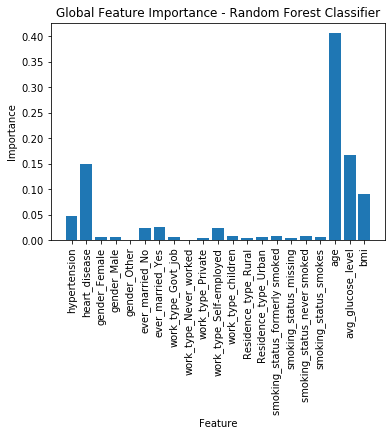

[5.24735036e-02 1.43874077e-01 2.68715051e-03 3.84072981e-03
 2.73883579e-07 2.42249454e-02 2.73123767e-02 2.56688282e-03
 2.61261931e-05 5.68302760e-03 2.24787733e-02 1.08449764e-02
 2.84488998e-03 1.91312852e-03 3.05591332e-03 4.11638223e-03
 4.96560590e-03 5.68566261e-03 4.78443276e-01 1.43215638e-01
 5.97466601e-02]


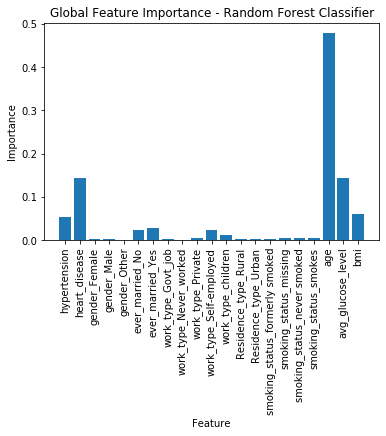

[4.50712645e-02 1.31150509e-01 5.67455733e-03 5.09994604e-03
 1.88854566e-06 1.99982212e-02 2.83888648e-02 3.32109850e-03
 3.54132919e-05 5.51846235e-03 1.97244400e-02 9.10131647e-03
 4.85696383e-03 4.65871050e-03 9.06948521e-03 5.83756308e-03
 4.25784319e-03 5.39373133e-03 4.38425391e-01 1.67227926e-01
 8.71864035e-02]


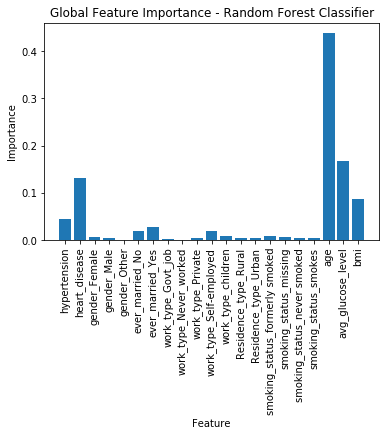

[4.86209754e-02 1.23165273e-01 7.84507930e-03 8.41510441e-03
 2.96796498e-06 1.66164700e-02 2.41309375e-02 5.94033398e-03
 1.99583428e-05 9.32859319e-03 1.58208404e-02 6.13924792e-03
 7.42942941e-03 5.36032767e-03 9.79288532e-03 7.40233924e-03
 9.48075819e-03 5.95003652e-03 4.04402102e-01 1.76591217e-01
 1.07545124e-01]


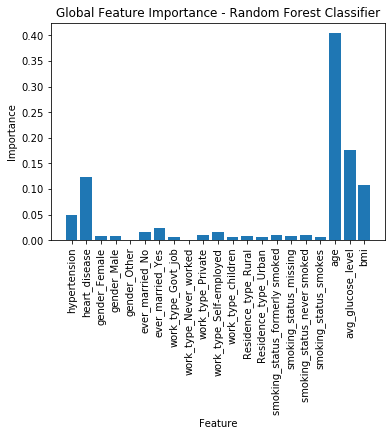

[3.99658248e-02 1.37216950e-01 3.90026618e-03 5.49490366e-03
 9.37278098e-07 1.93719769e-02 2.26507410e-02 4.10934844e-03
 3.10300930e-05 7.40581021e-03 1.54356944e-02 7.50411282e-03
 4.72994726e-03 3.83617497e-03 6.31297689e-03 5.03689542e-03
 8.57540334e-03 7.85232096e-03 4.48148181e-01 1.57497990e-01
 9.49225157e-02]


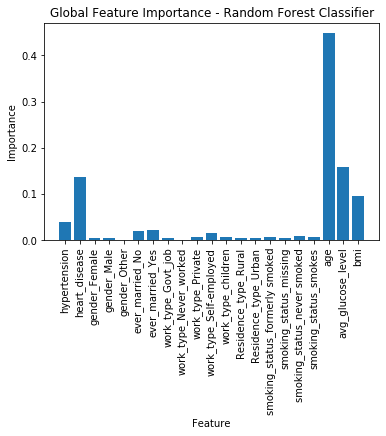

In [197]:
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                        random_state = 294)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=294)

ds = [8, 5, 7, 9, 8]
ss = [300, 363, 291, 201, 273]
ind = 0
for train_index, CV_index in kf.split(X_other, y_other):
    X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
    y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]
        
    X_train_, X_CV_, X_test_ = preprocess(X_train, X_CV, X_test, random_state=294)

    clf_rf = RandomForestClassifier(n_estimators=100, random_state=294, max_depth=ds[ind], min_samples_split=ss[ind])
    clf_rf.fit(X_train_, y_train)
    imp = clf_rf.feature_importances_
    
    print(imp)
    plt.bar(range(len(imp)), imp)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title("Global Feature Importance - Random Forest Classifier")
    plt.xticks(range(len(imp)), proc_ftrs, rotation='vertical')
    plt.savefig('../figures/random_forest_global_ftr_importance{}'.format(ind), dpi=300, bbox_inches = "tight")
    plt.show()
    ind += 1

#### SVC

In [ ]:
def ML_pipeline_kfold_svc(X, y, random_state, n_folds):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                        random_state = random_state)
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    f1_scores = []
    best_paras_f1 = []
    
    for train_index, CV_index in kf.split(X_other, y_other):
        X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
        y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]

        X_train_, X_CV_, X_test_ = preprocess(X_train, X_CV, X_test, random_state)
        
        C = np.logspace(-3, 5, 20)
        gamma = np.logspace(-10, 3, 20)
        paras = [(c, g) for c in C for g in gamma]
        clfs = []
        thresholds = []
        CV_score_f1 = []

        for c, g in paras:
            clf = SVC(C=c, gamma=g)
            clf.fit(X_train_, y_train)
            y_train_prob = clf.predict_proba(X_train_)
            thres = min([prob2 for [prob1, prob2] in y_train_prob])
            y_CV_prob = clf.predict_proba(X_CV_)
            y_CV_prob = [prob2 for [prob1, prob2] in y_CV_prob]
            y_CV_pred = [1 if prob>thres else 0 for prob in y_CV_prob]
            
            CV_score_f1.append(f1_score(y_CV, y_CV_pred))
            thresholds.append(thres)
            clfs.append(clf)
            

        best_c_f1 = paras[np.argmax(CV_score_f1)][0]
        best_g_f1 = paras[np.argmax(CV_score_f1)][1]
        best_paras.append((best_c_f1, best_g_f1))
        clf = clfs[np.argmax(CV_score)]
        test_scores.append(clf.score(X_test_,y_test))
        best_paras_f1.append((best_c_f1, best_g_f1))
        clf = clfs[np.argmax(CV_score_f1)]
        thres = thresholds[np.argmax(CV_score_f1)]
        y_test_prob = clf.predict_proba(X_test_)
        y_test_prob = [prob2 for [prob1, prob2] in y_test_prob]
        y_test_pred = [1 if prob>thres else 0 for prob in y_test_prob]
        f1_scores.append(f1_score(y_test,y_test_pred))
        
    best_para_f1 = best_paras_f1[np.argmax(f1_scores)]
    return best_para_f1, f1_scores    

f1_scores_svc = []
for i in range(10):
    random_state = 42*i
    best_para_f1, f1_scores = ML_pipeline_kfold_random_forest(X, y, random_state, 5)
    f1_scores_svc.append(f1_scores)
    print('random state = {}:'.format(random_state))
    print('Best c is {} and best gamma is {}.'.format(best_para_f1[0], best_para_f1[1]))
    
mean_f1_svc = np.mean(f1_scores_svc)
std_f1_svc = np.std(f1_scores_svc)
print('test f1 score:', np.around(mean_f1_svc,3), '+/-', np.around(std_f1_svc,3))

# EDA

In [ ]:
df = pd.read_csv('../data/stroke.csv')
df['smoking'].fillna(value='missing', inplace=True)

df['stroke'].replace(to_replace=0, value='not stroke', inplace=True)
df['stroke'].replace(to_replace=1, value='stroke', inplace=True)

df['hypertension'].replace(to_replace=0, value='No', inplace=True)
df['hypertension'].replace(to_replace=1, value='Yes', inplace=True)

df['heart_disease'].replace(to_replace=0, value='No', inplace=True)
df['heart_disease'].replace(to_replace=1, value='Yes', inplace=True)

### Numerical Feature -- age

In [ ]:
categories = df['stroke'].unique()
bin_range = (df['age'].min(), df['age'].max())

for c in categories:
    plt.hist(df[df['stroke']==c]['age'], alpha=0.5, label=c, range=bin_range, bins=20, density=True)
plt.legend()
plt.ylabel('pdf')
plt.xlabel('age')
plt.tight_layout()
plt.savefig('../figures/age_hist.png', dpi=300)
plt.show()

In [ ]:
dataset = [df[df['stroke']=='not stroke']['age'].values,
           df[df['stroke']=='stroke']['age'].values]

plt.violinplot(dataset = dataset)
plt.xticks([1,2], ['not stroke','stroke'])
plt.ylabel('age')
plt.savefig('../figures/age_violin.png', dpi=300)
plt.show()

### Numerical Feature -- avg_glucose_level

In [ ]:
categories = df['stroke'].unique()
bin_range = (df['avg_glucose_level'].min(), df['avg_glucose_level'].max())

for c in categories:
    plt.hist(df[df['stroke']==c]['avg_glucose_level'], alpha=0.5, label=c, range=bin_range, bins=20, density=True)
plt.legend()
plt.ylabel('pdf')
plt.xlabel('avg_glucose_level')
plt.axvline(x=70, color='r')
plt.axvline(x=126, color='r')
plt.tight_layout()
plt.savefig('../figures/avg_glucose_level_hist.png', dpi=300)
plt.show()

In [ ]:
dataset = [df[df['stroke']=='not stroke']['avg_glucose_level'].values,
           df[df['stroke']=='stroke']['avg_glucose_level'].values]

plt.violinplot(dataset = dataset)
plt.xticks([1,2], ['not stroke', 'stroke'])
plt.ylabel('avg_glucose_level')
plt.savefig('../figures/avg_glucose_level_violin.png', dpi=300)
plt.show()

### Numerical Feature -- bmi

In [ ]:
categories = df['stroke'].unique()
bin_range = (df['bmi'].min(), df['bmi'].max())

for c in categories:
    plt.hist(df[df['stroke']==c]['bmi'], alpha=0.5,
             label=c, range=bin_range, bins=20, density=True)

plt.legend()
plt.ylabel('pdf')
plt.xlabel('bmi')
plt.axvline(x=18.5, color='r')
plt.axvline(x=25, color='r')
plt.tight_layout()
plt.savefig('../figures/bmi_hist.png', dpi=300)
plt.show()

### Categorical Feature -- hypertension

In [ ]:
count_matrix = df.groupby(['hypertension', 'stroke']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color=('steelblue', 'powderblue'))
plt.ylabel('fraction of people in group')
plt.ylim(0.93,1)
plt.savefig('../figures/hypertension_bar.png')
plt.show()

In [ ]:
sns.boxplot(x = df['hypertension'], y = df['age'], hue = df['stroke'], palette = 'Blues')
plt.savefig('../figures/hyper_age_stroke')

### Categorical Feature -- heart_disease

In [ ]:
count_matrix = df.groupby(['heart_disease', 'stroke']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color=('steelblue', 'powderblue'))
plt.ylabel('fraction of people in group')
plt.ylim(0.9,1)
plt.savefig('../figures/heart_disease_bar.png')
plt.show()

In [ ]:
sns.boxplot(x = df['heart_disease'], y = df['age'], hue = df['stroke'], palette = 'Blues')
plt.savefig('../figures/heart_age_stroke')

### Categorical Feature -- gender

In [ ]:
count_matrix = df.groupby(['gender', 'stroke']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color=('steelblue', 'powderblue'))
plt.ylabel('fraction of people in group')
plt.ylim(0.97, 1)
plt.savefig('../figures/gender_bar.png')
plt.show()

### Categorical Feature -- work_type

In [ ]:
count_matrix = df.groupby(['work_type', 'stroke']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color=('steelblue', 'powderblue'))
plt.ylabel('fraction of people in group')
plt.ylim(0.95, 1)
plt.savefig('../figures/work_type_bar.png')
plt.show()

### Categorical Feature -- smoking_status

In [ ]:
count_matrix = df.groupby(['smoking_status', 'stroke']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color=('steelblue', 'powderblue'))
plt.ylabel('fraction of people in group')
plt.ylim(0.96, 1)
plt.savefig('../figures/smoking_status_bar.png')
plt.show()

In [ ]:
sns.boxplot(x = df['smoking_status'], y = df['age'], hue = df['stroke'], palette = 'Blues')
plt.savefig('../figures/smoking_age_stroke', dpi = 300, bbox_inches = "tight")

### Categorical Feature -- Residence_type

In [ ]:
count_matrix = df.groupby(['Residence_type', 'stroke']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color=('steelblue', 'powderblue'))
plt.ylabel('fraction of people in group')
plt.ylim(0.96, 1)
plt.savefig('../figures/Residence_type_bar.png')
plt.show()

### Categorical Feature -- ever_married

In [ ]:
count_matrix = df.groupby(['ever_married', 'stroke']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0)
count_matrix_norm.plot(kind='bar', stacked=True, color=('steelblue', 'powderblue'))
plt.ylabel('fraction of people in group')
plt.ylim(0.97, 1)
plt.savefig('../figures/ever_married_bar.png')
plt.show()

In [ ]:
sns.boxplot(x = df['ever_married'], y = df['age'], hue = df['stroke'], palette = 'Blues')
plt.savefig('../figures/ever_age_stroke')